# Procesamiento de Imágenes - Trabajo Práctico N°4
## Grupo 3
* Santiago Arribere
* Matías Francois
* Joaquín Gaytan
* Pablo Scheinfeld

# Ejercicio 7

## Ecualización de Histograma

In [1]:
from PIL import Image
import numpy as np
import sys
# Add the folder path to the sys.path list
sys.path.append('../../src/helpers/')
from plot_histogram import plot_histogram
from compare_images import compare_images


La ecualización de un histograma es una técnica empleada para ajustar el contraste de una imagen. A modo de introducción, en una imagen en la que el histograma se encuentre distribuido de una forma poco uniforme, el contraste no resulta adecuado. Por el contrario, el contraste es óptimo cuando los valores del histograma se encuentran distribuidos uniformemente.

Para comprobarlo, a continuación se muestran dos imágenes con sus respectivos histogramas. Estas imágenes fueron obtenidas de la página 
<a href="https://ichi.pro/es/introduccion-a-la-ecualizacion-de-histogramas-para-la-mejora-de-imagenes-digitales-72596068212291" title="Ichi">Ichi</a>.


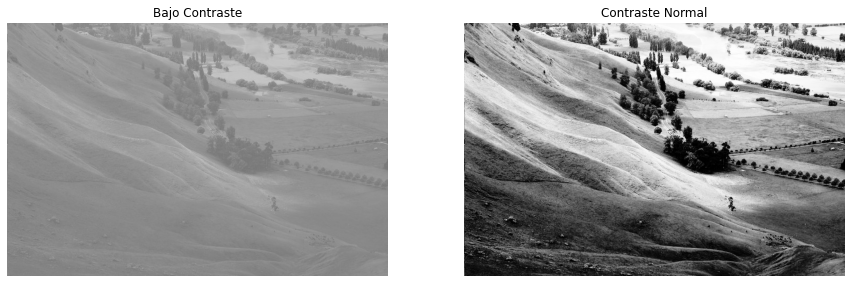

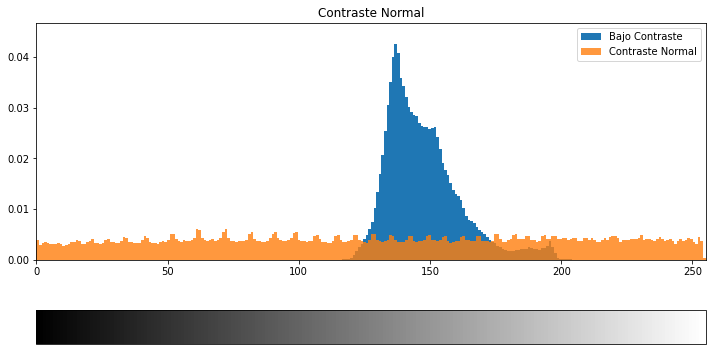

In [2]:
low_contrast_ex = np.array(Image.open('../../assets/ej7/low_contrast_ex.jpeg'), dtype=np.uint8)  # Open
normal_contrast_ex = np.array(Image.open('../../assets/ej7/normal_contrast_ex.png'), dtype=np.uint8)  # Open

compare_images([low_contrast_ex, normal_contrast_ex], ['Bajo Contraste', 'Contraste Normal'])

_ = plot_histogram(low_contrast_ex, new_image=normal_contrast_ex, title = 'Contraste Normal', label='Bajo Contraste', new_label='Contraste Normal')

Se observa que la imagen izquierda presenta considerablemente poco contraste y esto se representa en el histograma por los valores muy focalizados en el centro de la escala. Por otro lado, la imagen derecha visualmente cuenta con un contraste adecuado. A su vez, su histograma se encuentra casi uniformemente distribuido alrededor de toda la escala de grises.

Dado el comportamiento mencionado, la ecualización del histograma busca aplanar el histograma de una imagen, distribuyendo los valores de forma tal que se mejore su contraste. Sin embargo, al trabajar con imágenes digitales, el histograma resultante no será perfectamente uniforme, ya que existe una cantidad limitada de valores que se asignan a cada píxel. Entonces, cada valor de gris será mapeado a un nuevo valor con el objetivo de aplanar el histograma lo máximo posible.

Siento r un valor de gris de entrada y s el valor de gris al que es mapeado, se busca una transformación T tal que: $$s = T(r)$$

### Caso continuo

En un caso continuo, la transformación a encontrar generaría el siguiente resultado, donde cada valor de salida tiene la misma probabilidad.

![](../../assets/ej7/hist_eq.png)

Para encontrar la transformación, se parte de las características de las funciones densidad de probabilidad.

$$\int_0^1{p_r(r)\cdot dr} = 1$$
$$\int_0^1{p_s(s)\cdot ds} = 1$$

Entonces, $$\int_0^1{p_r(r)\cdot dr} = \int_0^1{p_s(s)\cdot ds} = 1$$

Y, como $s = T(r)$,

$$p_s(s)\cdot ds = p_r(r)\cdot dr |_{r = T^{-1}(s)}$$

En el caso continuo, tomando al rango de 0 a L-1, todos los valores de salida tendrían la misma probabilidad, igual a $\frac{1}{L-1}$, dado que es una fdp uniforme.

Así, $$p_s(s) = \frac{1}{L-1}$$

Reemplazando:

$$p_s(s)\cdot = p_r(r)\cdot \frac{dr}{ds} |_{r = T^{-1}(s)} = \frac{1}{L-1}$$
$$\frac{dr}{ds} |_{r = T^{-1}(s)} =  \frac{1}{L-1} \cdot \frac{1}{p_r(r)}$$

Por último,

$$s = T(r) = (L-1) \cdot \int_0^r{p_r(w)\cdot dw} $$

### Caso discreto

En el caso discreto, la expresión de s resulta:

$$s_k = T(r_k) = (L-1) \cdot \sum_{j=0}^k{p_r(r_j)} $$

Y como, $p_r(r_j) = \frac{n_j}{M \cdot N}$, en una imagen de M x N píxeles:

$$s_k = T(r_k) = \frac{L-1}{M \cdot N} \cdot \sum_{j=0}^k{n_j} $$

En la expresión anterior $n_j$ representa cada píxel con un valor de gris $r_j$. 

En resumen, para todos los píxeles de cada valor $r_j$ se obtiene un nuevo valor $s_j$ por el cual se los reemplazará. El nuevo valor coincide con multiplicar a $(L-1)$ por la función de distribución acumulada hasta el momento. La imagen resultante debería contener una función de distribución acumulada que crezca de forma aproximadamente lineal, ya que se busca que la función de densidad de probabilidad de la imagen sea aproximadamente uniforme.

## Implementación
### Mediante OpenCV

Text(0.5, 1.0, 'Imagen con bajo contraste')

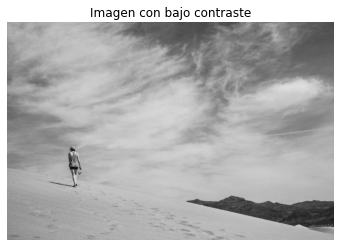

In [3]:
import cv2
from matplotlib import pyplot as plt
path = "../../assets/ej7/low_contrast_2.png"
low_contrast_ex2 = cv2.imread(path, 0)
plt.imshow(low_contrast_ex2,cmap='gray')
plt.axis('off')
plt.title('Imagen con bajo contraste')

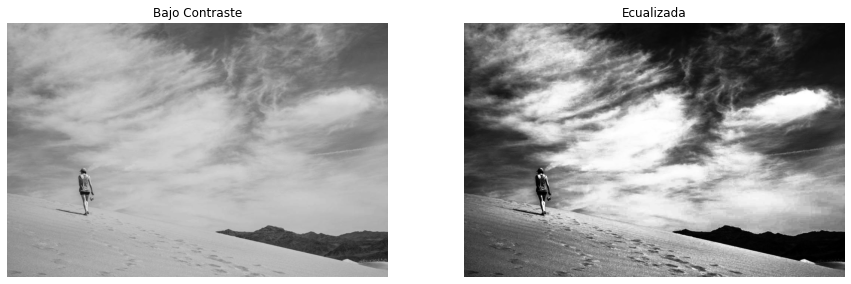

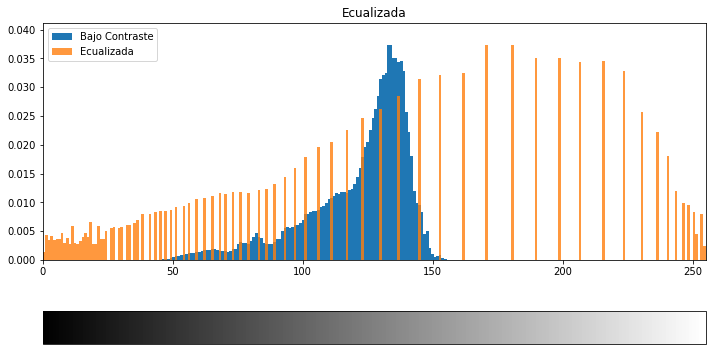

In [4]:
equ = cv2.equalizeHist(low_contrast_ex2)

compare_images([low_contrast_ex2, equ], ['Bajo Contraste', 'Ecualizada'])

_ = plot_histogram(low_contrast_ex2, new_image=equ, title = 'Ecualizada', label='Bajo Contraste', new_label='Ecualizada')

Al comparar las imágenes se observa que la resultante de ecualizar el histograma presenta claramente un mayor contraste. Asimismo, dicho contraste resulta adecuado y no se excede de lo esperado. De esta forma, se logró mejorar la calidad de la imagen original.

Analizando el histograma, se puede destacar que este fue transformado de tal forma que ocupe todo el rango de valores. Además, si bien no se logró que este sea constante debido a que el rango de valores es discreto, el nuevo histograma es mucho más cercano a una distribución uniforme que el original.

A continuación, para estudiar si el histograma resultante es realmente cercano a una distribución uniforme, se le superpone su función de distribución acumulada. Dado que en el caso de una función de probabilidad uniforme, la función de distribución acumulada debería ser una función lineal creciente, se espera que en este caso el comportamiento sea similar.

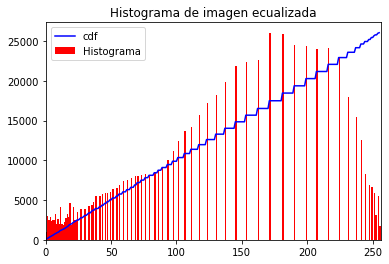

In [5]:
# Histograma
hist,bins = np.histogram(equ.flatten(),256,[0,256])
# Calculo función de distribución acumulada
cdf = hist.cumsum()
cdf_normalized = cdf * float(hist.max()) / cdf.max()

# Plot
plt.plot(cdf_normalized, color = 'b')
plt.hist(equ.flatten(),256,[0,256], color = 'r')
plt.xlim([0,256])
plt.legend(('cdf','Histograma'), loc = 'upper left')
plt.title('Histograma de imagen ecualizada')
plt.show()

Efectivamente, el histograma resultante presenta una función de distribución acumulada muy similar a una función lineal creciente. La única diferencia se encuentra en la presencia de pequeños escalones que se deben a que el rango de valores es discreto.

### Implementación propia

A continuación se implementa y se prueba una función que realicé la ecualización del histograma de una imagen de entrada. Para realizarlo se tuvieron en cuenta las expresiones matemáticas incluidas anteriormente.

In [6]:
def equalize_hist(image, L=256):
    new_image = np.zeros(shape=image.shape, dtype=np.uint8)
    
    flattened = image.copy().flatten()
    ac = 0
    for j in range(L):  #Itera por todos los valores de gris.
        # Cuenta cantidad de píxeles con valor j.
        n_j = np.count_nonzero([flattened == j])
        # Calcula la probabilidad de dicho valor.
        p = n_j / len(flattened)
        # Actualiza función de distribución acumulada
        ac += p
        # Calcula valor de gris de reemplazo.
        s_j = (L-1)*ac
        # Reemplaza el valor j por el valor s_j
        new_image[image == j] = np.uint8(np.round(s_j))
    return new_image

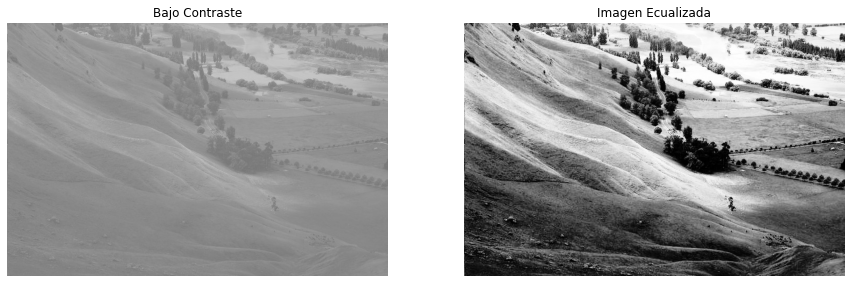

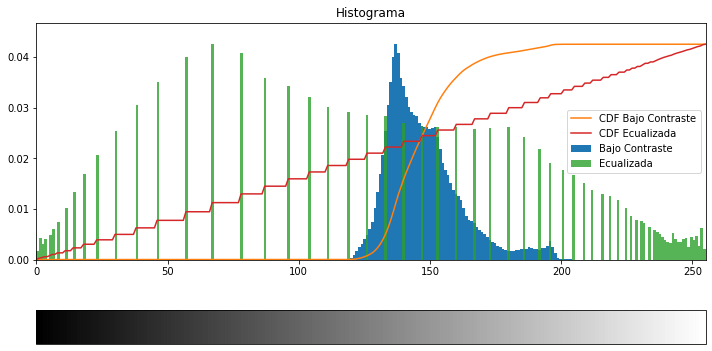

In [7]:
img2 = np.array(Image.open('../../assets/ej7/low_contrast_ex.jpeg'), dtype=np.uint8)  # Open
ec = equalize_hist(img2)

compare_images([img2, ec], ['Bajo Contraste', 'Imagen Ecualizada'])
_ = plot_histogram(img2, new_image=ec, title = 'Histograma', label='Bajo Contraste', new_label='Ecualizada', plotCDF=True)

Se observa que el algoritmo implementado funcionó adecuadamente. La imagen resultante presenta un contraste considerablemente más adecuado que la imagen original. A su vez, el histograma de la imagen ecualizada presenta una función de densidad acumulada que se asemeja más a una función lineal creciente que el histograma original.

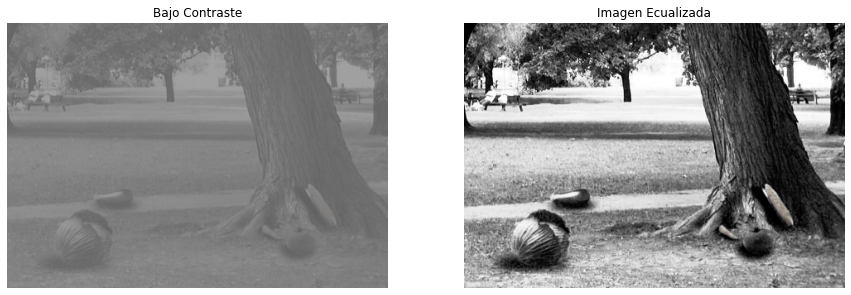

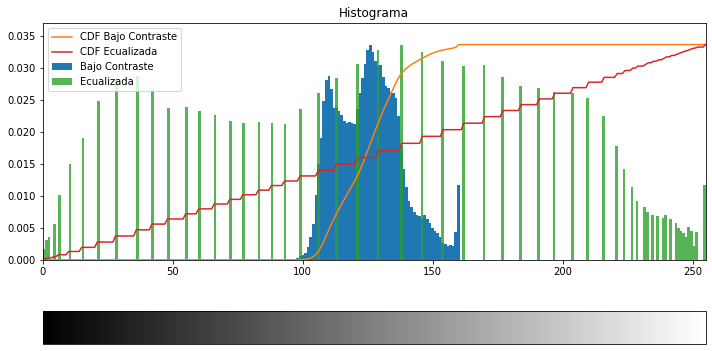

In [8]:
lc_3 = np.array(Image.open('../../assets/ej7/low_contrast_3.png'), dtype=np.uint8)  # Open
ec_3 = equalize_hist(lc_3)

compare_images([lc_3, ec_3], ['Bajo Contraste', 'Imagen Ecualizada'])
_ = plot_histogram(lc_3, new_image=ec_3, title = 'Histograma', label='Bajo Contraste', new_label='Ecualizada', plotCDF=True)

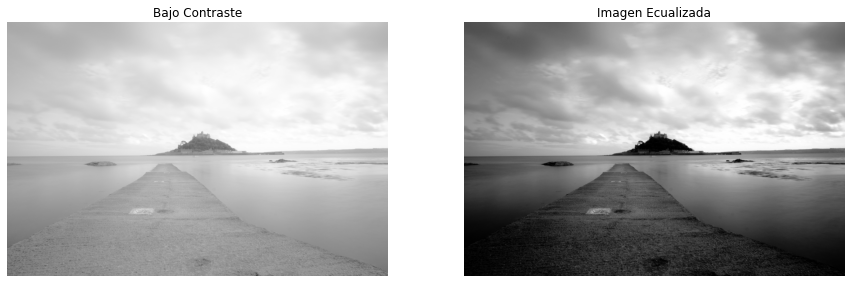

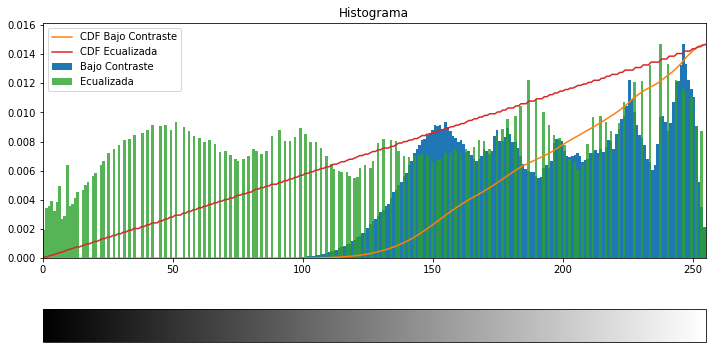

In [9]:
lc_4 = np.array(Image.open('../../assets/ej7/low_contrast_4.jfif'), dtype=np.uint8)  # Open
ec_4 = equalize_hist(lc_4)

compare_images([lc_4, ec_4], ['Bajo Contraste', 'Imagen Ecualizada'])
_ = plot_histogram(lc_4, new_image=ec_4, title = 'Histograma', label='Bajo Contraste', new_label='Ecualizada', plotCDF=True)

## Conclusión

En el presente ejercicio se desarrolló el concepto de ecualización de un histograma. Con respecto a su objetivo, se mostró que aumenta a un valor óptimo el contraste de las imágenes. A lo largo del desarrollo se detallaron los pasos matemáticos requeridos para transformar a la imagen original y luego se implementó un algoritmo capaz de efectuar la ecualización. En primer lugar se utilizó la librería OpenScale y luego se llevó a cabo un algoritmo propio. En todos los casos los resultados fueron favorables, obteniendo imágenes de mayor calidad, con un contraste más adecuado que las originales. Además, se compararon los histogramas de las imágenes de entrada y de salida, analizando su diferencia y comprobando que la función de distribución acumulada de la imagen ecualizada se aproxima al de una función lineal creciente, como era esperado.